# The Formal Syntax and Semantics of Venn Diagrams




This project is a Python-based implementation of the formal syntax and semantics of Venn diagrams. It provides a mathematically precise framework for deriving, manipulating, visualizing, and evaluating Venn diagrams. In particular we will provide a framework  whereby the following hold:  
- Each Venn Diagram will be specified by a finite number of applications of a finite number of syntactic rules to an enumerable vocabulary. 
- The syntactic derivation of a Venn Diagram will be specified in a parse tree on analogy with the syntactic derivation of a formula of a natural or formal language.
- The truth conditions of a Venn Diagram will be compositionally specified in terms of its syntactic derivation. 


In his 1880 article "On the Diagrammatic and Mechanical Representation of Propositions and Reasonings", John Venn introduced a scheme of diagrammatic representation which he took to be an improvement over traditional Eulerian circles--the basic system of representation was further developed in a textbook (Venn 1894). Paradigmatically, a Venn Diagram is given by a set of overlapping basic regions. The basic regions represent sets in a domain. The intersection, union, or relative complement of regions in a diagram represent the intersection, union, or relative complement of the sets in the domain represented by these regions. 

In order to represent regions and points, and various operations on them, we will leverage the Shapely library for geometric operations. And to render the diagrams we will use Matplotlib for the visualization.

In [1]:
from shapely.geometry import Point, Polygon, MultiPolygon, LineString

import matplotlib.pyplot as plt
from matplotlib.patches import Path, PathPatch

We will also use some standard libraries for randomizing and copying

In [2]:
import random
import copy

A Venn diagram is a certain formal object. Each diagram consists of a set of basic regions in a background region. Out of these basic regions sub-regions can be defined by set-theoretic intersection, union, and relative complement.

The basic vocabulary consists of a set of basic regions $X_1, X_2,\ldots$ and a background $R$. We will define the background $R$ as a finite square in the plane, and the basic regions are just any subset of $R$, and here we somewhat randomly specify six regions, $A_1$ through $A_6$.

In [3]:
# the plane (or a finite square of it)
R = Polygon([(-3, -3), (-3, 5), (5, 5), (5, -3)])

# center points for some basic regions
centers = [(1, 2), (0, 0), (2, 0), (3, 2), (1, 1), (1.75, .85)]

# specify six basic regions
A1 = Point(centers[0]).buffer(2)
A2 = Point(centers[1]).buffer(2)
A3 = Point(centers[2]).buffer(2)
A4 = Point(centers[3]).buffer(1.5)
A5 = Point(centers[4]).buffer(.3)
A6 = Point(centers[5]).buffer(2.2)

basic_regions = {A1,A2,A3,A4,A5,A6}
# the labels are just for rendering 
labels = {
    A1: '$A_1$', 
    A2: '$A_2$', 
    A3: '$A_3$', 
    A4: '$A_4$',
    A5: '$A_5$',
    A6: '$A_6$',
}


The first syntax rule is `form`. This rule derives an undecorated diagram from a sequence $X_1,\ldots, X_n$ of basic regions provided these regions satisfy what is known as the *mutual overlap constraint*. The way Venn put the contraint was as follows:

> What we ultimately have to do is to break up the entire field before us into a definite number of classes > or compartments which are mutually exclusive and collectively exhaustive." (Venn 1894, 111)

We will define `form`, and then turn to the `mutual_overlap_constraint`. 

In [4]:
# form rule
def form(X1, X2, X3):
    D = {"base": [X1,X2,X3], "destroyed":[], "saved":[]}
    return D

Note that formally, a Venn diagram is identified by a dictionary `{"base": [...],"destroyed":[...],"saved":[...]}`, where 'base' is a list of its basic regions, 'destroy' is list its destroyed regions, and 'saved' is a list of its saved regions. The defintion of destruction and salvation are coming soon.

The mutual overlap constaint is easy to grasp intuitively, but a bit complicated to define. Formally we can put the mutual overlap constraint like this:

> Definition. A (non-empty) set of basic regions $\{X_1,\ldots, X_n\}$ of the plane $R$ meets the **mutual overlap constraint** iff for all $\Gamma$: if $\Gamma \subseteq \{X_1,\ldots, X_n\}$, then $\bigcap\big(\Gamma \cup \{R\}\big) - \bigcup\big(\{X_1,\ldots, X_n\}- \Gamma\big) \neq\emptyset$.

The constraint simply guarantees that the cells of the diagram are non-empty. To encode the rule we first need a way of getting the powerset of a set of basic regions.

In [5]:
# powerset helper function
def powerset(s):
    if not s:
        return [set()]
    subsets = powerset(s[:-1])
    item = s[-1]
    return subsets + [subset.union({item}) for subset in subsets]

Given that helper function then the constraint can be encoded as follows:

In [55]:
# the mutual overlap constaint 
def mutual_overlap_constraint(basic_regions, background):
    for subset in powerset(basic_regions):
        # sets for regions in subset and not in subset
        subset_regions = subset | {background}
        remaining_regions = set(basic_regions) - subset
        
        # initialize result
        result = None
        
        # in
        for region in subset_regions:
            reg_poly = Polygon(list(region.exterior.coords))
            if result is None:
                result = reg_poly
            else:
                result = result.intersection(reg_poly)
        
        # out
        for region in remaining_regions:
            reg_poly = Polygon(list(region.exterior.coords))
            if result is not None:
                result = result.difference(reg_poly)
        
        # check if result is non-empty
        if result.is_empty:
            return False
    
    return True


For example, `form(A1,A2,A3)` will result in a diagram with basic regions $A_1$, $A_2$, and $A_3$. These regions are officially Shapley polygons, which will be easier to visualise once we render the diagrams.

In [56]:
form(A1,A2,A3)

{'base': [<POLYGON ((3 2, 2.99 1.804, 2.962 1.61, 2.914 1.419, 2.848 1.235, 2.764 1.05...>,
  <POLYGON ((2 0, 1.99 -0.196, 1.962 -0.39, 1.914 -0.581, 1.848 -0.765, 1.764 ...>,
  <POLYGON ((4 0, 3.99 -0.196, 3.962 -0.39, 3.914 -0.581, 3.848 -0.765, 3.764 ...>],
 'destroyed': [],
 'saved': []}

If the the overlap contraint is not meet, the rule won't apply. So, for example, given the way the regions were defined above, {$A_4$, $A_2$, $A_3$} will not meet the contraint. (Again this will become more clear after rendering.)

In [57]:
mutual_overlap_constraint([A4,A2,A3],R)

False

Next, to decorate a diagram, we first need rules for constructing regions of a diagram out of the basic regions and background. The regions of a diagram include its basic regions and the background $R$. Further regions can be specified as non-empty intersections, unions, and relative complements of these regions. Thus, the syntax will have three operations for forming regions out of other regions `inter`, `union`, and `comp`. We encode these set-theroretic operations using Shapley's built in methods. The resulting regions are just as one would expect.

In [58]:
# set operation rules
def inter(X1,X2):
    return X1.intersection(X2)
    
def union(X1,X2):
    return X1.union(X2)
    
def comp(X1,X2):
    return X1.difference(X2)

To indicate that the set represented by a region is empty--we, in Venn's words "destroy" the region by shading it grey. Hence we introduce the rule `destroy`, which take a diagram and a region to a new diagram.

In [59]:
# destruction rule
def destroy(D,X):
    D_prime = copy.deepcopy(D) 
    D_prime["destroyed"].append(X)
    return D_prime


A shaded region represents emptiness but a non-shaded region does not represent non-emptiness. Thus, Venn Diagrams were initially not equipped to represent that a certain region was non-empty. As Venn noted the representation of non-emptiness requires "some additional form of diagrammatical notation" (Venn 1883). Venn initially suggested different kinds of marking or shading: one kind for "destruction" and one kind for "salvation". This would get unwieldy with multiple overlapping shadings. So Venn suggested an alternative proposal: 
>"perhaps the simplest way is to use numerals to mark the compartments one or other of which is to be secured by each particular proposition" (Venn 1894).

On this proposal, one places occurrences of a numeral in various cells. The diagram then represents that the set associated with the union of these cells is non-empty. The `save` rule takes a diagram and an arrary of saved cells, to a new diagram.

In [60]:
# salvation rule
def save(D,cell_array):
    D_prime = copy.deepcopy(D)
    D_prime["saved"].append(cell_array)
    return D_prime

The syntactic derivation of a diagram will be encoded in a tree, or really nested lists. The derivation of a diagram is either (i) the derivation of a basic diagram `[form, X1, X2, X3]`, where X1, X2, and X3 are basic regions (the set of which meets the mutual overlap contraint), or (ii) the derivation of complex diagram `[destroy, D, X]` or `[save, D, [X1,..,Xn]]` from a well-formed diagram D and either a well-formed region X, or an array of cells `[X1,..,Xn]`. We will define two functions that recurvely check an input for well-formedness: `is_wellformed_region` and `is_wellformed_diagram`.

In [61]:
# structures encoding the syntactic derivations regions and diagrams 
def is_wellformed_region(input):
    if isinstance(input, Polygon):
        return True
    elif isinstance(input, list) and len(input) == 3:
        return all(isinstance(child, Polygon) or is_wellformed_region(child) for child in input[1:])
    return False
    
def is_wellformed_diagram(input):
    if not isinstance(input, list) or not (3 <= len(input) <= 4):
        return False

    if input[0] == form:
        all_basic = all(isinstance(child, Polygon) for child in input[1:])
        mutual_overlap = mutual_overlap_constraint(input[1:], R)
        if not all_basic:
            return False
        if not mutual_overlap:
            return False
    elif input[0] == destroy:
        if not is_wellformed_diagram(input[1]):
            return False
        if not is_wellformed_region(input[2]):
            return False
    elif input[0] == save:
        if not is_wellformed_diagram(input[1]):
            return False
        for reg in input[2]:
            if not is_wellformed_region(reg): # strictly need further restriction to cells
                return False
    else:
        return False

    return True


So, for example,`[destroy,[form,A1,A2,A3],[inter,A1,[inter,A2,A3]]]` encodes the syntactic derivation of the diagram `destroy(form(A1,A2,A3),inter(A2,A3))`.

In [66]:

derivation =  [
                    destroy,
                    [
                        form, 
                         A1, 
                         A2, 
                         A3
                    ],
                    [
                        inter,
                        A1,
                        [
                            inter,
                            A2,
                            A3
                        ]
                    ]
                ]



In [67]:
is_wellformed_diagram(derivation) 

True

To derive a diagram the syntax rules are applied as we proceed up the tree.

In [72]:
def syn(tree):
    # check if tree is a terminal node
    if isinstance(tree, Polygon):
        return tree
    # else if non-terminal node
    elif isinstance(tree, list) and tree[0] in [inter,union,comp]:
        result = tree[0](syn(tree[1]), syn(tree[2]))
        return result
    elif isinstance(tree, list) and tree[0] == form:
        result = tree[0](syn(tree[1]),syn(tree[2]),syn(tree[3]))
        return result
    elif isinstance(tree, list) and tree[0] == destroy:
        result = tree[0](syn(tree[1]), syn(tree[2]))
        return result
    elif isinstance(tree, list) and tree[0] == save:
        reg_array = []
        for reg_der in tree[2]:
            reg = syn(reg_der)
            reg_array.append(reg)
        result = tree[0](syn(tree[1]), reg_array)
        # result = tree[0](*[syn(child) for child in tree[1:]])
        return result
        
    # else invalid tree
    else:
        return None

In [73]:
syn([destroy,[form,A1,A2,A3],[inter,A1,[inter,A2,A3]]])


{'base': [<POLYGON ((3 2, 2.99 1.804, 2.962 1.61, 2.914 1.419, 2.848 1.235, 2.764 1.05...>,
  <POLYGON ((2 0, 1.99 -0.196, 1.962 -0.39, 1.914 -0.581, 1.848 -0.765, 1.764 ...>,
  <POLYGON ((4 0, 3.99 -0.196, 3.962 -0.39, 3.914 -0.581, 3.848 -0.765, 3.764 ...>],
 'destroyed': [<POLYGON ((1.943 0.236, 1.765 0.152, 1.581 0.086, 1.39 0.038, 1.196 0.01, 1 ...>],
 'saved': []}

In [74]:
syn([destroy,[form,A1,A2,A3],[inter, A1, [inter, A2, A3]]]) == destroy(form(A1,A2,A3),inter(A1,inter(A2,A3)))

True

In [75]:
syn([save,[form,A1,A2,A3],[[inter, A2, A3],A1]])

{'base': [<POLYGON ((3 2, 2.99 1.804, 2.962 1.61, 2.914 1.419, 2.848 1.235, 2.764 1.05...>,
  <POLYGON ((2 0, 1.99 -0.196, 1.962 -0.39, 1.914 -0.581, 1.848 -0.765, 1.764 ...>,
  <POLYGON ((4 0, 3.99 -0.196, 3.962 -0.39, 3.914 -0.581, 3.848 -0.765, 3.764 ...>],
 'destroyed': [],
 'saved': [[<POLYGON ((1.99 -0.196, 1.962 -0.39, 1.914 -0.581, 1.848 -0.765, 1.764 -0.94...>,
   <POLYGON ((3 2, 2.99 1.804, 2.962 1.61, 2.914 1.419, 2.848 1.235, 2.764 1.05...>]]}

Notice that `syn([destroy,[form,A1,A2,A3],[inter, A1, [inter, A2, A3]]])` and `syn([destroy,[form,A1,A2,A3],[inter, A2, [inter, A1, A3]]])` are distinct derivation that should result in the same diagram. It doesn't matter if you intersect A2 with A3 and intesect the result with A1 or if you intersect A1 with A3 and intesect the result with A2.  But with Shapely, two different Polygons can represent the same geometric shape, even if they are specified in different ways. For example, two Polygons that have the same set of coordinates but in a different order. So two Polygons might be distinct even if that are topologically equivalent.

In [76]:
region1 = inter(A1,inter(A2,A3)) 
region2 = inter(A2,inter(A1,A3))

# differnt Shapley Pologon objects that coorespond to the same regions
region1 == region2

False

In [77]:
# topologically equivleant, i.e. same region of the plane
region1.equals(region2)

True

So if we want to check whether or not two derivations result in the same diagram we need to check for topological equivelance between the elements in their sets of base regions, destroyed regions, and saved regions, respectively. 

In [78]:
# helper function for topological equivelance
def topo_equivalance(region_list1, region_list2):
    # check if the sets have the same number of elements
    S1 = set(region_list1)
    S2 = set(region_list2)
    
    if len(S1) != len(S2):
        return False

    # check if each Polygon in S1 has an equal counterpart in S2
    for polygon1 in S1:
        found_match = False
        for polygon2 in S2:
            if polygon1.equals(polygon2):
                found_match = True
                break
        if not found_match:
            return False

    return True

# check two diagrams for equivelance
def diagrams_equal(diagram1,diagram2):
    bases_equal = topo_equivalance(diagram1["base"], diagram2["base"])
    destroys_equal = topo_equivalance(diagram1["destroyed"], diagram2["destroyed"])
    saves_equal = topo_equivalance(diagram1["saved"], diagram2["saved"])

    if bases_equal and destroys_equal and saves_equal:
        return True

    else:
        return False

diagram1 = destroy(form(A1,A2,A3),inter(A1,inter(A2,A3)))
diagram2 = destroy(form(A1,A2,A3),inter(A2,inter(A1,A3)))

# check if the sets are the same (topologically equivalent)
result = diagrams_equal(diagram1,diagram2)

print(result) # True


True


That is it for the formal syntax. But much of this is easier to understand with visual aid. So let's figure out how to render these Shapley geometries that are the building blocks of our syntax. We will use Matplotlib for the rendering. So essentially we need to convert the Shapley polygons and so on, into Matplotlib coordinates. This is a bit difficult, and at times a bit fiddly to get everything looking good. We potentially have Polygons with holes in them (so not just simple shapes), we potentially have disconnected shapes which will become what Shapley calls MultiPolygons (these are arrarys of polygons), and so on. So we have to do a lot of translating and it isn't very elegant. 

We first have a helper function that handles the complications with the shading, and espeically the shading of polygons with holes.  

In [79]:
# helper function to generate destroyed patches (potentially with holes in them)
def create_destroyed_patch(region):
    
    # get coords
    exterior_destroyed = list(region.exterior.coords)
    if region.interiors:
        interior_destroyed = [list(interior.coords) for interior in region.interiors]
    else:
        interior_destroyed = []
        
    # get paths    
    exterior_path = Path(exterior_destroyed)
    interior_paths = [Path(interior) for interior in interior_destroyed]
    
    # get codes
    combined_codes = [Path.MOVETO] + [Path.LINETO] * (len(exterior_path) - 2) + [Path.CLOSEPOLY]
    combined_vertices = list(exterior_path.vertices)
    for interior_path in interior_paths:
        combined_codes += [Path.MOVETO] + [Path.LINETO] * (len(interior_path) - 2) + [Path.CLOSEPOLY]
        combined_vertices += list(interior_path.vertices)
        
    # return destroyed patch
    return PathPatch(
        Path(combined_vertices, combined_codes),
        fill=True,
        facecolor='gray',
        edgecolor='none'
    )

We then have a helper function that will handle the placement of occurrences of a numeral or index in various regions. Essentially we will put a numeral randomly in the selected region, while avioding clashes with other numerals, edges, labels, and so on.

In [80]:
# helper function to place salvation indices in cells when called
def random_point(region, used_points, label_points, base_regions_coords):
        while True:
            min_x, max_x = region.bounds[0], region.bounds[2]
            min_y, max_y = region.bounds[1], region.bounds[3]
            x = random.uniform(min_x, max_x)
            y = random.uniform(min_y, max_y)
            random_point = Point(x, y)

            # buffers
            basic_padding = 0.3
            region_buffered = region.buffer(-basic_padding)
            border_padding = 1
            border_buffered = R.buffer(-border_padding)

            # check if the point is in region and not too close to other points, edges, and labels
            if random_point.within(region_buffered) and random_point.within(border_buffered):
                try:
                    used_point_distance = min(random_point.distance(used_point) for used_point in used_points)
                except ValueError:
                    used_point_distance = 0.3
                    
                regions_lines = [LineString(region_coords) for region_coords in base_regions_coords]
                line_distance = min(random_point.distance(region_line) for region_line in regions_lines)
                                    
                label_distance = min(random_point.distance(label_point) for label_point in label_points)
                
                if label_distance >= (basic_padding*2) and used_point_distance >= basic_padding and line_distance >= basic_padding:
                    return random_point
                

Finally, we have out function that takes a diagram and renders it.

In [81]:
def render_venn(D):
    # create a Matplotlib figure 
    fig, ax = plt.subplots()
    
    # label the base regions
    X1 = D["base"][0]
    X2 = D["base"][1]
    X3 = D["base"][2]

    label_pos_X1 = (X1.centroid.x, X1.centroid.y+2.5)
    label_pos_X2 = (X2.centroid.x-2.5,X2.centroid.y)
    label_pos_X3 = (X3.centroid.x+2.5,X3.centroid.y)
    label_points = [Point(label_pos_X1),Point(label_pos_X2),Point(label_pos_X3)]

    # get base region coords
    base_regions_coords =[]
    for region in D["base"]:
        region_coords = list(region.exterior.coords)
        base_regions_coords.append(region_coords)
    
    # destruction rendering covering both polygons and multipolygons
    destroyed_patches = []
    for region in D["destroyed"]:
        if isinstance(region, MultiPolygon):
            for polygon in region.geoms:
                destroyed_patch = create_destroyed_patch(polygon)
                destroyed_patches.append(destroyed_patch)
        elif isinstance(region, Polygon):
            destroyed_patch = create_destroyed_patch(region)
            destroyed_patches.append(destroyed_patch)

    for destroyed_patch in destroyed_patches:
        ax.add_patch(destroyed_patch)

    # salvation rendering
    index = 1
    used_points = []
    regions = []
    
    for arr in D["saved"]:
        for region in arr:
            if region not in regions and not region.interiors:
                index_point = region.centroid
                used_points.append(index_point)
            else:
                index_point = random_point(region, used_points, label_points, base_regions_coords)
                used_points.append(index_point)
            ax.text(index_point.x, index_point.y, str(index), ha='center', va='center', fontweight='bold',fontsize=10)
            regions.append(region)
        index += 1
        
    # form rendering
    for region_coords in base_regions_coords:
        ax.add_patch(plt.Polygon(region_coords, fill=None))
     
    #labels
    ax.text(*label_pos_X1, labels[X1], ha='center', va='center', fontsize=12)
    ax.text(*label_pos_X2, labels[X2], ha='center', va='center', fontsize=12)
    ax.text(*label_pos_X3, labels[X3], ha='center', va='center', fontsize=12)

    # set the aspect ratio and axis limits so it looks right
    ax.set_aspect('equal')
    ax.set_xlim(-3, 5)
    ax.set_ylim(-2.5, 5)

    # remove graph junk, axis labels, and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # display
    plt.show()

With the rendering functions are set now we can derive some diagrams using our syntac rules and actually display them. For example, we can derive a Venn diagram `form(A1,A2,A6)` and then render it with `render_venn`.

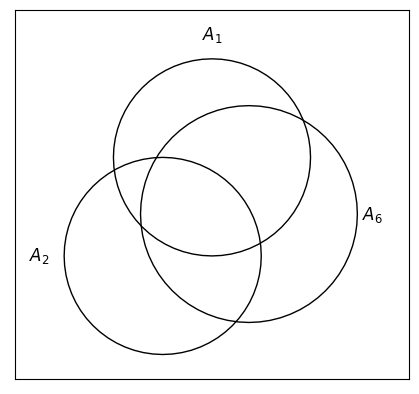

In [82]:
D = syn([form,A1,A2,A6])
render_venn(D)

Notice that the `form` rules doesn't throw any error. That is as it should be since the mutual overlap constraint is met. But consider a case were the constaint is not met.

In [83]:
mutual_overlap_constraint([A1,A2,A6],R)

True

But some set of basic regions will fail mutual overlap constraint, such as {A4,A2,A3} and so `[form,A4,A2,A3]` will not be a proper derivation.

In [84]:
is_wellformed_diagram([form,A4,A2,A3])

The regions do not meet the mutual overlap constraint


False

In [85]:
# the form rule will fail
syn([form,A4,A2,A3])


{'base': [<POLYGON ((4.5 2, 4.493 1.853, 4.471 1.707, 4.435 1.565, 4.386 1.426, 4.323 ...>,
  <POLYGON ((2 0, 1.99 -0.196, 1.962 -0.39, 1.914 -0.581, 1.848 -0.765, 1.764 ...>,
  <POLYGON ((4 0, 3.99 -0.196, 3.962 -0.39, 3.914 -0.581, 3.848 -0.765, 3.764 ...>],
 'destroyed': [],
 'saved': []}

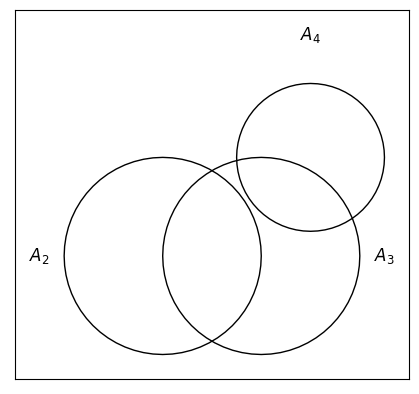

In [86]:
# We can hack the render_venn function to see what the result would be if it was allowed
render_venn({"base": [A4,A2,A3],"destroyed":[],"saved":[]})

Now let's quicky run through some examples using all the rules.

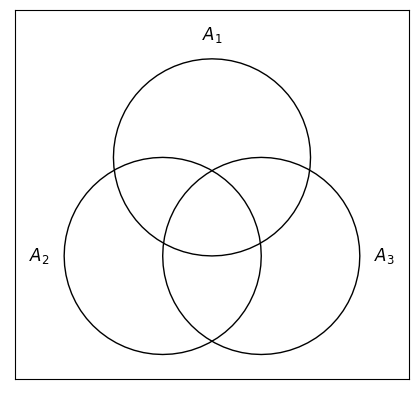

In [87]:
# base derivation
D0 = form(A1,A2,A3) # i.e. syn([form,A1,A2,A3])
render_venn(D0)

In [88]:
# derivation of the cells
a = comp(A1,union(A2,A3))
b = comp(inter(A1,A2), A3)
c = inter(A3,inter(A1,A2))
d = comp(inter(A1,A3),A2)
e = comp(A2,union(A1,A3))
f = comp(inter(A2,A3), A1)
g = comp(A3,union(A1,A2))
h = comp(R, union(A3,union(A1,A2)))

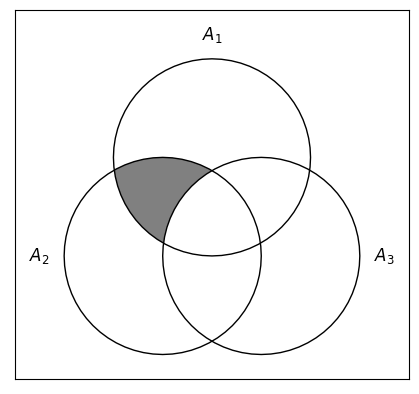

In [89]:
# destruction of cell b
D1 = destroy(D0,b)
render_venn(D1)

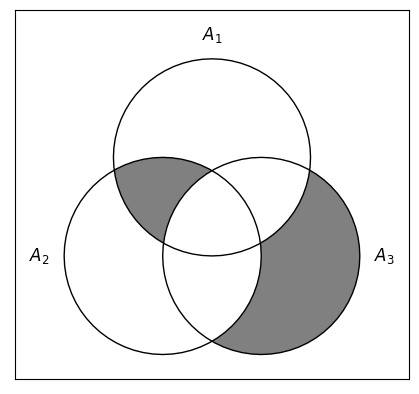

In [90]:
# destruction of cell g
D2 = destroy(D1,g)
render_venn(D2)

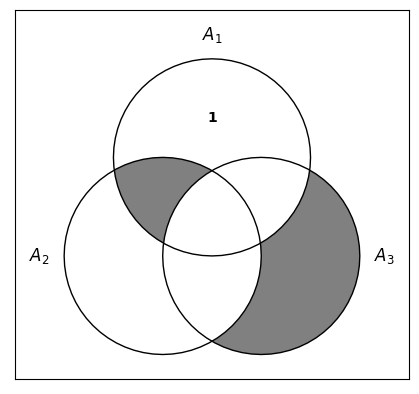

In [91]:
# salvation of cell a
D3 = save(D2,[a])
render_venn(D3)

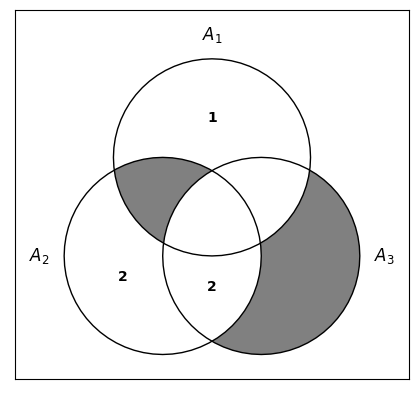

In [92]:
# alternative salvation of cell e or f
D4 = save(D3,[e,f])
render_venn(D4)

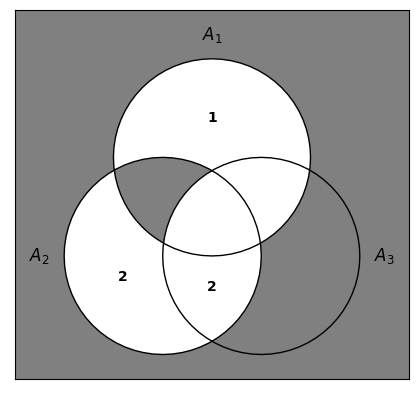

In [93]:
# destruction of exterior h
D5 = destroy(D4, h)
render_venn(D5)


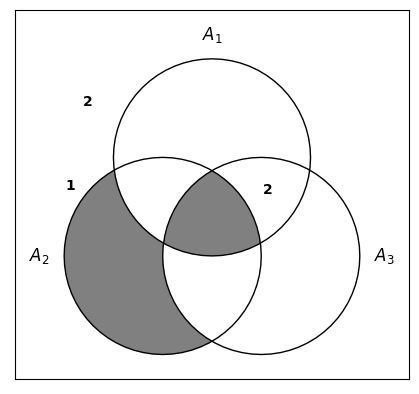

In [94]:
# example of a complex derivation
G0 = destroy(
        save(
            save(
                form(A1, A2, A3),
                [h]
            ),
            [h, d]
        ),
        union(c, e)
     )

render_venn(G0)

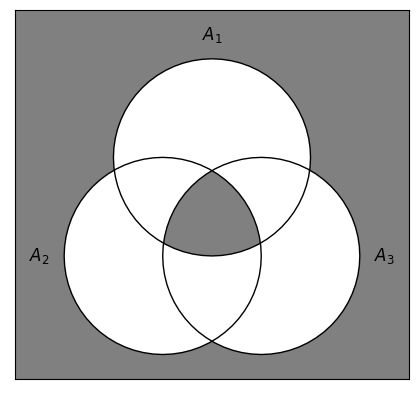

In [95]:
# another example of destruction
G1 = destroy(
        form(A1,A2,A3),
        union(c,h)
    )

render_venn(G1)

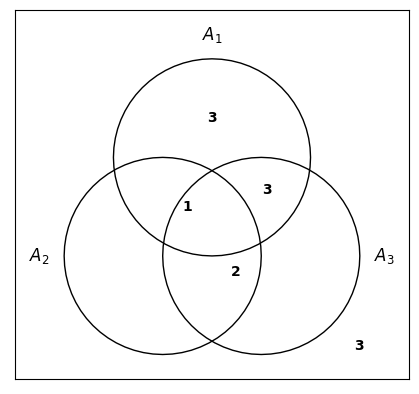

In [96]:
# another example of salvation
G2 = save(
        save(
            save(
                form(A1,A2,A3),
                [union(A1,A2)]
            ),
            [union(A1,A2)]
         ),
        [h,d,a]
     )

render_venn(G2)

Turning now to the semantics for diagrams.  The semantics is compositional in that each syntactic rule in the derivation of a diagram corresponds to a semantic rule in the derivation of its truth conditions. More formally, if $\alpha$ is a stage in the syntactic derivation of a diagram that results from applying formation rule $\mu$ to $\beta_1,\ldots,\beta_n$, then the semantic value of $\alpha$ is the result of applying from function $f_\mu$ to the semantic values of $\beta_1,\ldots,\beta_n$.

In [97]:
class Model:
    def __init__(self, universe, interpretation):
        self.universe = universe
        self.interpretation = interpretation

In [98]:
def is_region_arr(input):
    return not (is_wellformed_diagram(input) or is_wellformed_region(input))
# compositional semantics 
def sem(input):
    if input == R:
        return lambda M: M.universe
    elif isinstance(input, Polygon):
        return lambda M: M.interpretation(input)
    elif input == inter:
        return lambda M: lambda s1, s2: s1 & s2
    elif input == union:
        return lambda M: lambda s1, s2: s1 | s2
    elif input == comp:
        return lambda M: lambda s1, s2: s1 - s2
    elif input == form:
        return lambda M: lambda s1, s2, s3: True
    elif input == destroy:
        return lambda M: lambda p, s: p and (s == set())
    elif input == save:
        return lambda M: lambda p, s: p and (s != set())
    elif is_region_arr(input):
        return lambda M: set().union(*(sem(child)(M) for child in input))
    # composition via functional application
    else:       
       return lambda M: sem(input[0])(M)(*[sem(child)(M) for child in input[1:]])



In [99]:
U = {1,2,3,4,5}

I = lambda X: {
        A1: {1, 2},
        A2: {1},
        A3: set(),
    }.get(X) 

M1 = Model(U,I)




In [100]:
sem(R)(M1)

{1, 2, 3, 4, 5}

In [101]:
sem(A1)(M1)

{1, 2}

In [102]:
sem(A2)(M1)

{1}

In [103]:
sem(A3)(M1)

set()

In [104]:
sem([inter,A1,A2])(M1)

{1}

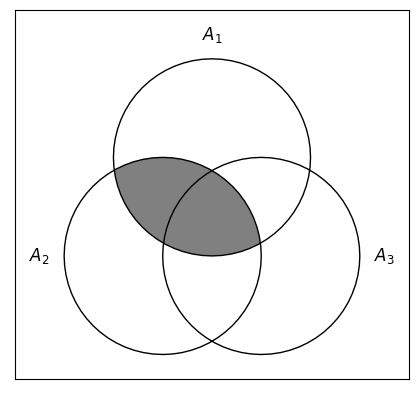

In [105]:
example1 = [destroy,[form,A1,A2,A3],[inter,A1,A2]]

render_venn(syn(example1))



In [106]:
sem(example1)(M1)

False

In [107]:
U2 = {1,2,3,4,5}

I2 = lambda X: {
        A1: {1},
        A2: {2},
        A3: {1},
    }.get(X) 

M2 = Model(U2,I2)

In [108]:
sem(example1)(M2)

True

We could roll up into one both the syntax and rendering along with the semantic evaluaiton at a model. The funtion `eval` takes a diagram and a model and gives a rendering of the diagram and a print out of the model and result as a side-effects.

In [109]:
def eval(diagram, model):
    syntax_output = syn(diagram)
    semantic_output = sem(diagram)
    render_venn(syntax_output)
    
    print("Universe: ", model.universe)
    print("Interpretation: ")
    for x in [A1,A2,A3,A4,A5,A6]:
        if model.interpretation(x) is not None:
            print(f'          A{labels[x][3]}:', model.interpretation(x))
    
    print(f"Result: The diagram is {semantic_output(model)} on the model.")
    
    

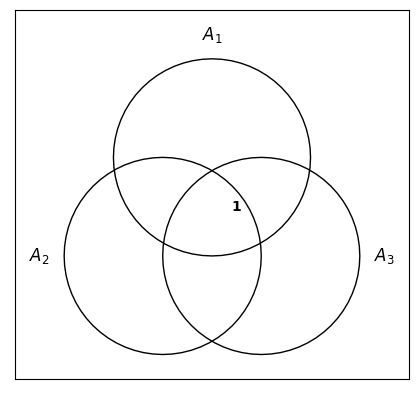

Universe:  {1, 2, 3, 4, 5}
Interpretation: 
          A1: {1, 2}
          A2: {1}
          A3: set()
Result: The diagram is False on the model.


In [110]:
K1 = [save,[form,A1,A2,A3],[[inter,A1,A3]]]

eval(K1,M1)

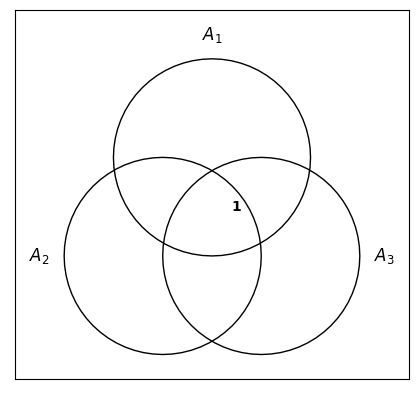

Universe:  {1, 2, 3, 4, 5}
Interpretation: 
          A1: {1}
          A2: {2}
          A3: {1}
Result: The diagram is True on the model.


In [111]:
eval(K1,M2)

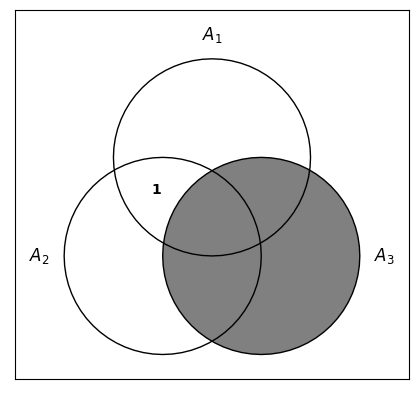

Universe:  {1, 2, 3, 4, 5}
Interpretation: 
          A1: {1, 2}
          A2: {1}
          A3: set()
Result: The diagram is True on the model.


In [112]:
K2 = [save,[destroy,[form,A1,A2,A3],A3],[[comp,[inter,A1,A2],A3]]]
eval(K2,M1)

## References

- Hammer, Eric, & Danner, Norman. 1996. Towards a Model Theory of Diagrams. Journal of Philosophical Logic, 25(5), 463–482.

- Moktefi, Amirouche, & Pietarinen, Ahti-Veikko. 2015. On the Diagrammatic Representation of Existential Statements with Venn Diagrams. Journal of Logic, Language and Information, 24(4), 361–374.

- Moktefi, Amirouche, & Shin, Sun-Joo. 2012. A history of logic diagrams. Pages 611–682 of: Handbook of the History of Logic, vol. 11. Elsevier.

- Shin, Sun-Joo. 1994. The logical status of diagrams. Cambridge University Press.

- Venn, John. 1880. On the Diagrammatic and Mechanical Representation of Propositions and Reasonings. Philosophical Magazine, 9(59), 1–18.

- Venn, John. 1894. Symbolic Logic. Macmillan and Company.